In [1]:
import pandas as pd
import numpy as np
import geopandas
import matplotlib.pyplot as plt
from shapely.geometry import Point
import os
import folium
import json
from datetime import *
from fuzzywuzzy import fuzz
import joypy
%matplotlib inline  
plt.style.use('fivethirtyeight')

C:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Read the raw data, the data from Yelp, merge them together and clean the variables

In [2]:
df = pd.read_csv("raw_data.csv")
df_restaurant = pd.read_csv("restaurants_raw_data.csv")

### Convert inspection date to datetime and keep a count for the past 15 months of the number of inspections


### We delete the businesses with no inspections or with more than 10 different inspections in the past 15 months given that they do not show possible recency/accuracy

In [3]:
df["inspection_date_datetime"] = pd.to_datetime(df["inspection_date"])
last_year_date = pd.Timestamp(date(2017, 6, 15))
df_last_year = df[df["inspection_date_datetime"] > last_year_date].drop_duplicates(["camis","inspection_date_datetime"])
df["inspection_count"] = df["camis"].map(df_last_year["camis"].value_counts())
df["inspection_count"] = df["inspection_count"].fillna(0)
df["inspection_count"] = df["inspection_count"].astype(int)
df = df[df["inspection_count"] != 0]
df = df[df["inspection_count"] <= 10]
df = df[df["score"] >= 0]

### We also clean the format of a few points

In [4]:
df["cuisine_description"] = np.where(df['cuisine_description'] == "CafÃ©/Coffee/Tea", "Coffee/Tea", df["cuisine_description"])
df["boro"] = np.where(df['boro'] == "BRONX", "Bronx", df["boro"])
df["boro"] = np.where(df['boro'] == "MANHATTAN", "Manhattan", df["boro"])
df["boro"] = np.where(df['boro'] == "BROOKLYN", "Broooklyn", df["boro"])
df["boro"] = np.where(df['boro'] == "QUEENS", "Queens", df["boro"])
df["boro"] = np.where(df['boro'] == "STATEN ISLAND", "Staten Island", df["boro"])

### We start with some initial visualizations to find any possible trend

### The number of violations has trended higher for the past 4 years

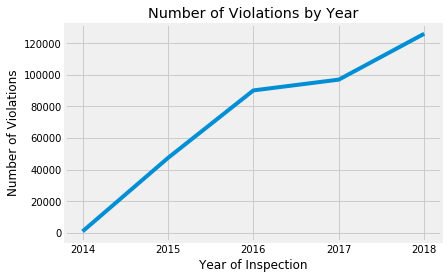

In [5]:
df_year = df.groupby(df["inspection_date_datetime"].map(lambda x: x.year))["score"].count()
plt.plot(df_year.index,df_year)
plt.title("Number of Violations by Year")
plt.ylabel("Number of Violations")
plt.xlabel("Year of Inspection")
plt.xticks([2014,2015,2016,2017,2018])
plt.savefig("Violations by Year", bbox_inches = "tight")
plt.show()

### The average score by inspection is going higher as the amount of violations is going up too (the higher the number of violations, the higher the scores) 

### This could be explained by the fact that one badly rated restaurant sees many violations and can skew the results to a higher number

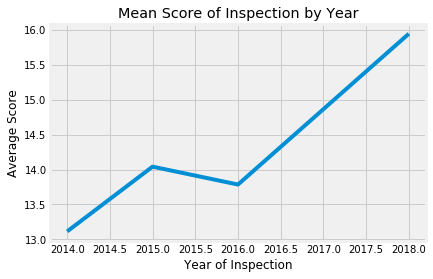

In [6]:
df_inspections = df.drop_duplicates(["camis","inspection_date_datetime"])
df_year_mean = df_inspections.groupby(df["inspection_date_datetime"].map(lambda x: x.year))["score"].mean()
plt.plot(df_year_mean.index,df_year_mean)
plt.title("Mean Score of Inspection by Year")
plt.ylabel("Average Score")
plt.xlabel("Year of Inspection")
plt.show()

### Confirming this theory, the median score has not trended higher

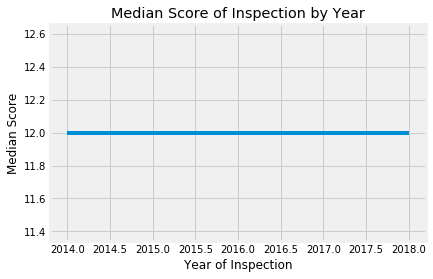

In [7]:
df_year_median = df_inspections.groupby(df["inspection_date_datetime"].map(lambda x: x.year))["score"].median()
plt.plot(df_year_median.index,df_year_median)
plt.title("Median Score of Inspection by Year")
plt.ylabel("Median Score")
plt.xlabel("Year of Inspection")
plt.show()

### Confirming this, the distributions have not changed meaningfully

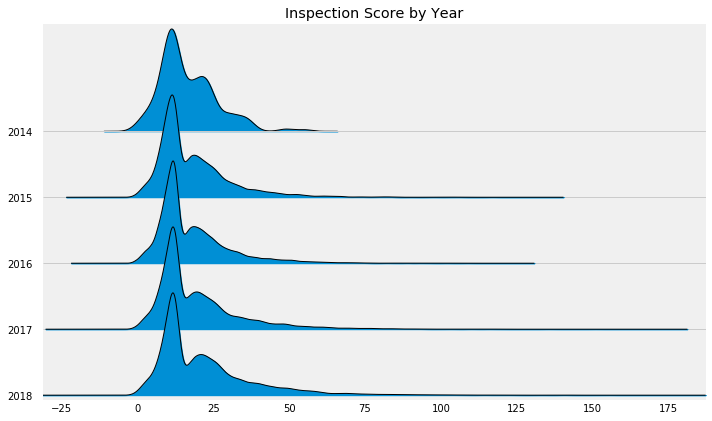

In [8]:
df["year"] = df["inspection_date_datetime"].map(lambda x: x.year)
fig, axes = joypy.joyplot(df, by="year", column="score", range_style='own',grid="y", ylim='own', linewidth=1, legend=False,figsize=(10,6),title="Inspection Score by Year")
plt.savefig("JoyPlot By Year", bbox_inches = "tight")

### We find a seasonality effect with winters seeing more violations

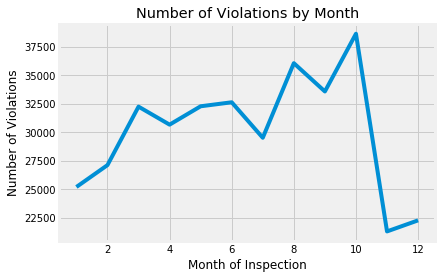

In [9]:
df_month = df.groupby(df["inspection_date_datetime"].map(lambda x: x.month))["score"].count()
plt.plot(df_month.index,df_month)
plt.title("Number of Violations by Month")
plt.ylabel("Number of Violations")
plt.xlabel("Month of Inspection")
plt.savefig("Violations by Month", bbox_inches = "tight")
plt.show()

### Within the months however, the distribution is generally the same, translating the fact that inspections may be less frequent rather than restaurants showing worse conditions

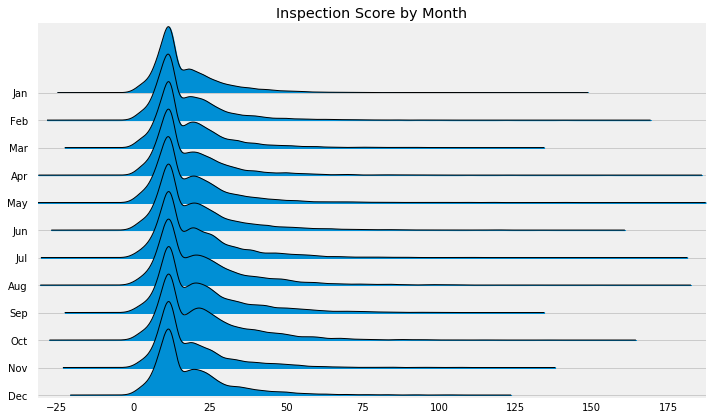

In [10]:
df["month"] = df["inspection_date_datetime"].map(lambda x: x.month)
labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
fig, axes = joypy.joyplot(df, by="month", column="score", labels = labels, range_style='own',grid="y", ylim='own', linewidth=1, legend=False,figsize=(10,6),title="Inspection Score by Month")
plt.savefig("Score by Month", bbox_inches = "tight")

### Keeping only one record for each restaurant and add the inspection count variable to the dataframe


In [11]:
df = df.sort_values("inspection_date_datetime",ascending=False)
df = df.drop_duplicates("camis")
df = df[df["grade"].notnull()]
df_restaurant = df_restaurant.drop_duplicates(["dba","street","zipcode"])
df_merged = df.merge(df_restaurant, on=["dba","street","zipcode"],how="left")

### Need to start by cleaning the mess that is the yelp data: keeping only the data that has price indication and the one where the name is close enough on Yelp


In [12]:
price_option=["$","$$","$$$","$$$$"]
df_price= df_merged[df_merged["yelp_price"].isin(price_option)]
df_price["yelp_fuzz"] = df_price[["dba","yelp_name"]].apply(lambda x: fuzz.partial_ratio(x['dba'], x['yelp_name'].upper()), axis=1)
df_cleaned = df_price[df_price["yelp_fuzz"]>65]
df_cleaned = df_cleaned.sort_values(by=["yelp_price"],ascending = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Reformatting a few columns to make them easier to manipulate and we create new variables for food, prices and hours of operations by applying our custom formatting

In [13]:
def reformat_price(price):
    #Simply reformats the price levels of the different businesses
    if price == "$":
        category = "1- Cheap"
    elif price == "$$":
        category = "2 - Reasonable"
    elif price == "$$$":
        category = "3 - Expensive"
    elif price == "$$$$":
        category = "4 - Luxurious"
    return category

def is_food(cuisine_description):
    #Separates food restaurants with the other types of business
    food = ["American","Peruvian","Soups & Sandwiches","Chinese","Sandwiches","Mexican","Chicken","Turkish","Sandwiches/Salads/Mixed Buffet","Hamburgers","Chinese/Japanese","Italian","Spanish","Latin (Cuban, Dominican, Puerto Rican, South & Central American)","French","Pizza/Italian","Creole","Pizza","Japanese","Seafood","Asian","African","Barbecue","Jewish/Kosher","Tapas","Caribbean","Salads","Steak","Tex-Mex","Mediterranean","Pakistani","Irish","Vegetarian","Bangladeshi","Australian","Thai","Soups","Middle Eastern","Russian","Indian","Brazilian","Greek","Korean","Vietnamese/Cambodian/Malaysia","Hotdogs","Hawaiian","Soul Food", "Filipino","Creole/Cajun","Eastern European","Armenian","Afghan","Chinese/Cuban","English","Polish","Continental","Hotdogs/Pretzels","German","Egyptian","Indonesian","Ethiopian","Moroccan","Portuguese","Californian","Cajun","Scandinavian","Southwestern","Chilean","Iranian","Polynesian","Czech","Basque"]
    other = ["Pancakes/Waffles","Not Listed/Not Applicable","Nuts/Confectionary","Fruits/Vegetables"]
    if cuisine_description in food:
        category = "Food"
    elif cuisine_description in other:
        category = "Other"
    else:
        category = cuisine_description
    
    return category

def give_grade(score):
    #Give grade based on the score of the inspection
    if score < 14:
        grade = "A"
    elif score < 28:
        grade = "B"
    else:
        grade = "C"
    
    return grade

In [14]:
df_cleaned["food"] = df_cleaned["cuisine_description"].apply(is_food)
df_cleaned["synthetic_grade"] = df_cleaned["score"].apply(give_grade)
df_cleaned["yelp_price"] = df_cleaned["yelp_price"].apply(reformat_price)

In [15]:
import ast
df_cleaned["yelp_hours"] = df_cleaned["yelp_hours"].fillna(0)

for restau in df_cleaned.index:
    if df_cleaned.loc[restau,"yelp_hours"] == 0:
        overnight = "N/A"
    else:
        overnight = ast.literal_eval(df_cleaned.loc[restau,"yelp_hours"])
        if type(overnight) == list:
            overnight = overnight[0]
        if overnight["open"][0]["is_overnight"] == True:
            overnight = "Overnight"   
        else:
            overnight = overnight["open"]
            try:
                if overnight[0]["day"] == overnight[1]["day"]:
                    overnight = "Closes for lunch"
                overnight = overnight[0]
                start = int(overnight["start"][0:2])
                end = int(overnight["end"][0:2])
                if end-start >= 12:
                    overnight = "Long Hours"
                else:
                    overnight = "Short Hours"
            except:
                overnight = "N/A"
    df_cleaned.loc[restau,"overnight"] = overnight

# We create a chloropleth to visualize the data by zipcode

### Aggregate the data per zipcode to create the choropleth

In [16]:
df_map = df_cleaned.dropna(subset=['zipcode'])
df_map.zipcode.unique()
df_map["zipcode"] = df_map["zipcode"].astype(int)
df = df_map.groupby("zipcode")["score"].mean() 
new_df = pd.DataFrame(data = {"zip": df.index, "mean_score": df}) 
df_proportion =  100*(df_map[df_map["score"] < 14].groupby("zipcode")["score"].count() / df_map.groupby("zipcode")["score"].count())
new_df = pd.DataFrame(data = {"zip": df.index,"proportion": df_proportion}) 
new_df["zip"] = new_df["zip"].astype(str)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### We prepare the map template for the choropleth

In [17]:
with open("nyc-zip-code-tabulation-areas-polygons.geojson","r") as jsonFile:
    data = json.load(jsonFile)
tmp = data
geozips = []
for i in range(len(tmp["features"])):
    if tmp["features"][i]["properties"]["postalCode"] in list(new_df["zip"].unique().astype(str)):
        geozips.append(tmp["features"][i])
        
new_json = dict.fromkeys(["type","features"])
new_json["type"] = "FeatureCollection"
new_json["features"] = geozips

open("updated-file.json","w").write(json.dumps(new_json, sort_keys = True, indent=4, separators = (",",": ")))

1763892

In [18]:
def create_map(table,zips,mapped_feature, add_text=""):
    #Create the map based on the zip-coded data and the feature
    nyc_geo = r"updated-file.json"
    m = folium.Map(location = [40.7128, -74.0060], zoom_start = 11)
    m.choropleth(
        geo_data = nyc_geo,
        fill_opacity = 0.7,
        line_opacity = 0.2,
        data = table,
        key_on = "feature.properties.postalCode",
        columns = [zips,mapped_feature],
        fill_color = "RdYlGn",
        legend_name = "Percentage of Restaurants Graded A Across NYC",
        threshold_scale= [75,80, 85,90, 95,100]
    )
    folium.LayerControl().add_to(m)
    m.save(outfile = mapped_feature + "_map.html")

### We create and store the chloropleth

In [ ]:
create_map(new_df,"zip","proportion")

### Refining as we map the zipcodes with their respective neighborhoods using (https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm), we find slight variability by neighborhood

In [ ]:
df_neighbor = pd.read_csv("neighbor_map.csv")
df_neighbor = pd.DataFrame(df_neighbor[["Neighborhood","ZIP"]], columns=['Neighborhood','ZIP'])
for restau in df_cleaned.index:
    zipcode = df_cleaned.loc[restau,"zipcode"].astype(int).astype(str)
    for neighborhood in df_neighbor.index:
        if zipcode in df_neighbor.loc[neighborhood,"ZIP"]:
            df_cleaned.loc[restau,"neighborhood"] = df_neighbor.loc[neighborhood,"Neighborhood"]
            break

In [ ]:
plot2df = 100*(df_cleaned[df_cleaned["score"] < 14].groupby("neighborhood")["camis"].count() / df_cleaned.groupby("neighborhood")["camis"].count())
plt.figure(figsize=(8,12))
plt.barh(plot2df.index,plot2df,color=['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c'])
plt.title("Restaurants Graded A by Neighborhood")
plt.style.use("fivethirtyeight")
plt.xlim((75,100))
plt.xlabel("Proportion of Restaurants Graded A")
plt.savefig("Restaurants Graded A by Neighborhood", bbox_inches = "tight")
plt.show()
df_cleaned.groupby("neighborhood")["camis"].count()

# Diving deeper in the data

### Looking at Overall Grades

In [ ]:
plot1df = df_cleaned.groupby("synthetic_grade")["camis"].count() / df_cleaned.groupby("synthetic_grade")["camis"].count().sum()

plt.pie(plot1df,autopct ="%1.1f%%",labels=plot1df.index)
plt.title("Proportion of Restaurants by Grade")
plt.axis("image")
plt.savefig("Proportion of Restaurants by Grade", bbox_inches = "tight")
plt.show()

#plot1df.plot(kind="pie",legend = False,labels=None,autopct = "%1.1f%%" ,subplots = True, figsize=(4,4),title="Proportion of Restaurants by Grade")

### There seems to be only a slight distinction by business type

In [ ]:
plot2df = 100*(df_cleaned[df_cleaned["score"] < 14].groupby("food")["camis"].count() / df_cleaned.groupby("food")["camis"].count())
plt.barh(plot2df.index,plot2df,color=['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c'])
plt.title("Restaurants Graded A by Type")
plt.style.use("fivethirtyeight")
plt.xlim((75,100))
plt.xlabel("Proportion of Restaurants Graded A")
plt.savefig("Restaurants Graded A by Type", bbox_inches = "tight")
df_cleaned.groupby("food")["camis"].count()

### Distributions are very similar by restaurants types

In [ ]:
df_cleaned = df_cleaned.sort_values("food")
fig, axes = joypy.joyplot(df_cleaned, by="food", column="score",range_style='own',grid="y", ylim='own', linewidth=1, legend=False,figsize=(10,6),title="Scores by Restaurants Types")
plt.savefig("Score by Type Joyplot", bbox_inches = "tight")

### Categorizing the businesses by whether or not they focus on food may help predict their health grade however

In [ ]:
df_cleaned["is_food_bool"] = [x == "Food" for x in df_cleaned["food"]]
#df_cleaned["is_other_bool"] = [x == "Other" for x in df_cleaned["food"]]
plot7df = 100*(df_cleaned[df_cleaned["score"] < 14].groupby("is_food_bool")["camis"].count() / df_cleaned.groupby("is_food_bool")["camis"].count())
plot7df.plot(kind="bar", subplots = True, figsize=(4,4),ylim = (0.8,1))
plt.bar(plot7df.index,plot7df,color=['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c'])
plt.title("Businesses Graded A by Type")
plt.ylabel("Proportion Graded A")
plt.xlabel("Is it Food?")
plt.ylim((75,100))
plt.savefig("Food vs no Food", bbox_inches = "tight")
plt.show()

### As the choropleth had already shown, there is no clear differentiation by borough

In [ ]:
df_boro = df_cleaned[df_cleaned["boro"] != "Missing"]
plot2df = 100*(df_boro[df_cleaned["score"] < 14].groupby("boro")["camis"].count() / df_boro.groupby("boro")["camis"].count())
plt.barh(plot2df.index,plot2df,color=['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c'])
plt.title("Restaurants Graded A by Borough")
plt.xlim((75,100))
plt.xlabel("Proportion Graded A")
plt.savefig("By Borough", bbox_inches = "tight")
plt.show()

### Surprisingly, aside from the highest price point, there is limited grade segmentation by price point

In [ ]:
plot4df = 100*(df_cleaned[df_cleaned["score"] < 14].groupby("yelp_price")["camis"].count() / df_cleaned.groupby("yelp_price")["camis"].count())
plt.barh(plot4df.index,plot4df,color=['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c'])
plt.title("Restaurants Graded A by Price")
plt.xlabel("Proportion Graded A")
plt.xlim((75,100))
plt.savefig("Proportion A by Price", bbox_inches = "tight")
plt.show()

### Correlation between the Yelp Rating and the Health Score is Limited as well

In [ ]:
df_cleaned["yelp_rating"].unique()
plt.scatter(df_cleaned["yelp_rating"],df_cleaned["score"],alpha=0.5)
plt.title("Inspection Score based on Yelp Rating")
plt.ylabel("Inspection Score")
plt.xlabel("Average Yelp Rating")
plt.savefig("Score by Rating", bbox_inches = "tight")
print(df_cleaned[["yelp_rating","score"]].corr())

### There seems to be a slight correlation with the number of reviews and the size of the chain when accounting for the difference in scale

In [ ]:
plt.scatter(df_cleaned["yelp_review_count"],df_cleaned["score"],alpha=0.5)
plt.title("Inspection Score based on Review Count")
plt.ylabel("Inspection Score")
plt.xlabel("Review Count")
plt.xscale("log")
df_cleaned["log_yelp_review_count"] = np.log(df_cleaned["yelp_review_count"])
plt.savefig("A by log of Review Count", bbox_inches = "tight")
print(df_cleaned[["log_yelp_review_count","score"]].corr())

### Even using an interaction term leveraging the review count and the rating, there is only a weak correlation

In [ ]:
df_cleaned["log_yelp_review_count_rating"] = df_cleaned["log_yelp_review_count"]*df_cleaned["yelp_rating"]
plt.scatter(df_cleaned["log_yelp_review_count_rating"],df_cleaned["score"],alpha=0.5)
plt.title("Inspection Score based on Review Count and Yelp Rating")
plt.ylabel("Inspection Score")
plt.xlabel("Log Review Count Times Yelp Rating")
print(df_cleaned[["log_yelp_review_count_rating","score"]].corr())
plt.show()

### The size of the chain seems to be slightly relevant in determining the restaurant's grade. Maybe it could be because as restaurants grow, they impose more sanitary requirements  and have more standardized processes

In [ ]:
df_cleaned["chain_size"] = df_cleaned["dba"].map(df_cleaned["dba"].value_counts())
plot5df = df_cleaned[df_cleaned["score"] < 14].groupby("chain_size")["camis"].count() / df_cleaned.groupby("chain_size")["camis"].count()
plt.scatter(plot5df.index, plot5df, alpha=0.5)
plt.title("Restaurants Graded A by Chain Size")
plt.ylabel("Proportion Graded A")
plt.xlabel("Chain Size")
plt.xscale("log")
df_cleaned["log_chain_size"] = np.log(df_cleaned["chain_size"])
plt.savefig("A by chain size", bbox_inches = "tight")
print(df_cleaned[["log_chain_size","score"]].corr())

### The number of inspection in the past 15 months seems like a relevant predictor for the health score of the business and seems to indicate that businesses with low health scores tend to remain so, despite the higher number of inspections

In [ ]:
plot8df = 100*(df_cleaned[df_cleaned["score"] < 14].groupby("inspection_count")["camis"].count() / df_cleaned.groupby("inspection_count")["camis"].count())
plt.bar(plot8df.index,plot8df,color=['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c'])
plt.title("Businesses Graded A by Inspection Count")
plt.ylabel("Proportion Graded A")
plt.xlabel("Number of Inspections in the Past 15 Months")
plt.ylim((30,100))
print(df_cleaned[["inspection_count","score"]].corr())
plt.savefig("A by inspection count", bbox_inches = "tight")
plt.show()

### Hours of operations seems to be for the most part irrelevant (aside maybe from restaurants that remain open overnight)

In [ ]:
plot9df = 100*(df_cleaned[df_cleaned["score"] < 14].groupby("overnight")["camis"].count() / df_cleaned.groupby("overnight")["camis"].count())
plt.bar(plot9df.index,plot9df,color=['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c'])
plt.title("Businesses Graded A by Hours of Operation")
plt.ylabel("Proportion Graded A")
plt.xlabel("Hours of Operation")
plt.ylim((75,100))
plt.savefig("A by hours of operation", bbox_inches = "tight")
plt.show()

### Being claimed on Yelp does not help predict the health grade

In [ ]:
plot9df = 100*(df_cleaned[df_cleaned["score"] < 14].groupby("yelp_is_claimed")["camis"].count() / df_cleaned.groupby("yelp_is_claimed")["camis"].count())
plt.bar(["False","True"],plot9df,color=['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c'])
plt.title("Businesses Graded A Claimed on Yelp")
plt.ylabel("Proportion Graded A")
plt.xlabel("Claimed on Yelp")
plt.ylim((75,100))
plt.savefig("A by claimed on yelp", bbox_inches = "tight")
plt.show()

# I conclude by standardizing my variables and store my dataframe in a new CSV to use it more easily in order to run my various models

In [ ]:
df_cleaned["std_yelp_review_count"] = (df_cleaned["yelp_review_count"]-df_cleaned["yelp_review_count"].mean())/df_cleaned["yelp_review_count"].std()
df_cleaned["std_chain_size"] = (df_cleaned["chain_size"]-df_cleaned["chain_size"].mean())/df_cleaned["chain_size"].std()
df_cleaned.to_csv("cleanedv1.csv")

In [ ]:
print(len(df_cleaned))